In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from scipy import stats
from collections import defaultdict
import shap
import datetime
import pickle
from sklearn.model_selection import StratifiedKFold

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [2]:
brand = 'Fendi'
df = pd.read_pickle('../data/%s_refined.pkl' %brand)

In [3]:
max_date = max(df['sc_date'])- datetime.timedelta(days=30)

## Labeling

In [4]:
df = df[df.apply(lambda x: x['sc_date'] == x['sc_date_first_date'], axis = 1)]

In [5]:
def labelling_model_1(row):
    if row['lifetime'] <= 30 and row['status'] == 'Complete' and row['ever_sold'] == 1:
        return 1.0
    elif row['lifetime'] > 30:
        return 0.0
    else:
        return None

In [6]:
df['label'] = df.apply(lambda x: labelling_model_1(x), axis = 1)
df_copy_test = pd.DataFrame(data=df)

In [7]:
count_df = df[df['sc_date_first_date'] < max_date]

In [8]:
count_df['label'].value_counts()

0.0    17
1.0    13
Name: label, dtype: int64

In [9]:
df = df[-df['label'].isnull()]
df_copy_train = pd.DataFrame(data=df)

In [10]:
df.columns

Index(['bags_brand', 'id', 'sc_date', 'bags_color', 'bags_condition',
       'materials_list', 'bags_price_refined', 'sold_price_refined',
       'retail_price_refined', 'likes', 'size', 'search_tradesy_fendi',
       'search_fendi', 'search_fendi_kan_i', 'sc_date_last_date',
       'sc_date_first_date', 'ever_sold', 'lifetime', 'status',
       'number_similar', 'avg_similar', 'original_to_avg', 'price_to_retail',
       'price_percentile', 'label'],
      dtype='object')

In [11]:
if len(set(df['size'])) > 1: 
    remove_cols = {'bags_brand', 'id', 'sc_date', 'sold_price_refined', 'likes', 'sc_date_first_date',
                                    'sc_date_last_date', 'lifetime', 'status', 'price_percentile', 'label', 'ever_sold'}
    ordinal_cols = ['bags_condition']
    categorical_cols = ['bags_color', 'materials_list', 'size']
else:
    remove_cols =  {'bags_brand', 'id', 'sc_date', 'sold_price_refined', 'likes', 'sc_date_first_date',
                                    'sc_date_last_date', 'lifetime', 'status', 'price_percentile', 'label', 'size', 'ever_sold'}
    ordinal_cols = ['bags_condition']
    categorical_cols = ['bags_color', 'materials_list']

In [12]:
def loo(feature_value, label_value, feature_dict):
    if len(feature_dict[feature_value]) == 1 or feature_value is None:
        return (sum(feature_dict['all']) - label_value) / (len(feature_dict['all']) - 1)
    else:
        return (sum(feature_dict[feature_value]) - label_value) / (len(feature_dict[feature_value]) - 1)

In [13]:
def LOO_encoder(train_df, test_df, categorical_cols, label_col):
    for feature in categorical_cols:
        feature_dict = defaultdict(list)
        for i, row in train_df.iterrows():
            feature_dict[row[feature]].append(row[label_col])
            feature_dict['all'].append(row[label_col])
        train_df['%s_loo'%feature] = train_df.apply(lambda x: loo(x[feature], x[label_col], feature_dict), axis = 1)
        test_df['%s_loo'%feature] = test_df.apply(lambda x: loo(x[feature], x[label_col], feature_dict), axis = 1)
    return train_df, test_df

In [14]:
def OH_encoder(train_df, test_df, ordinal_cols):
    for feature in ordinal_cols:
        feature_states = list(set(train_df[feature]).union(set(test_df[feature])))[:-1]
        for state in feature_states:
            train_df['%s_%s'%(feature,state)] = train_df[feature].map(lambda x: int(x == state))
            test_df['%s_%s'%(feature,state)] = test_df[feature].map(lambda x: int(x == state))
    return train_df, test_df

In [15]:
def refine_cols(cols):
    if brand == 'Chanel':
        for column in ['avg_similar', 'price_to_retail']:
            cols.remove(column)
    elif brand == 'Louis Vuitton':
        for column in ['avg_similar', 'price_to_retail']:
            cols.remove(column)
    elif brand == 'Gucci':
        for column in ['avg_similar']:
            cols.remove(column)
    elif brand == 'Saint Laurent':
        for column in []:
            cols.remove(column)
    elif brand == 'Fendi':
        for column in ['avg_similar']:
            cols.remove(column)
    return cols

In [16]:
models_quality = {'svm':{'t1': 0, 'f0': 0, 'f1': 0, 't0': 0},
                 'lr':{'t1': 0, 'f0': 0, 'f1': 0, 't0': 0},
                 'xgb':{'t1': 0, 'f0': 0, 'f1': 0, 't0': 0},
                 'ensemble':{'t1': 0, 'f0': 0, 'f1': 0, 't0': 0}}

In [17]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(df)

5

In [18]:
test_results_df = pd.DataFrame()

In [19]:
df.columns

Index(['bags_brand', 'id', 'sc_date', 'bags_color', 'bags_condition',
       'materials_list', 'bags_price_refined', 'sold_price_refined',
       'retail_price_refined', 'likes', 'size', 'search_tradesy_fendi',
       'search_fendi', 'search_fendi_kan_i', 'sc_date_last_date',
       'sc_date_first_date', 'ever_sold', 'lifetime', 'status',
       'number_similar', 'avg_similar', 'original_to_avg', 'price_to_retail',
       'price_percentile', 'label'],
      dtype='object')

In [20]:
sum(df['label'])

16.0

In [21]:
for train_index, test_index in skf.split(df[list(set(df.columns) - {'label'})], df['label']):
    df_train = df.iloc[train_index]
    df_test = df.iloc[test_index]
    
    df_train, df_test = LOO_encoder(df_train, df_test, categorical_cols, 'label')
    df_train, df_test = OH_encoder(df_train, df_test, ordinal_cols)
    cols = ['label'] + list(set(df_train.columns) - \
                            {'bags_color', 'bags_condition', 'materials_list', 'size', 'label'} - remove_cols)
    
    cols = refine_cols(cols)
    
    df_train = df_train[cols]
    df_test = df_test[cols]

    sm = SMOTE(random_state=42)
    X, y = sm.fit_resample(df_train[cols[1:]], df_train['label'])
    
    #support vector machines
    svm_clf = svm.SVC(probability=True)
    svm_clf.fit(X, y)
    df_test['svm_pred'] = svm_clf.predict(df_test[cols[1:]])
    df_test['svm_prob'] = [item[0] for item in svm_clf.predict_proba(df_test[cols[1:]])]
    df_test['svm_prob_false'] = [item[1] for item in svm_clf.predict_proba(df_test[cols[1:]])]
    
    # logistic regression
    lr_clf = LogisticRegression().fit(X, y)
    
    df_test['lr_pred'] = lr_clf.predict(df_test[cols[1:]])
    df_test['lr_prob'] = [item[0] for item in lr_clf.predict_proba(df_test[cols[1:]])]
    df_test['lr_prob_false'] = [item[1] for item in lr_clf.predict_proba(df_test[cols[1:]])]
    
    #xgboost
    xgb_clf = XGBClassifier()
    xgb_clf.fit(X, y)
    
    df_test['xgb_pred'] = xgb_clf.predict(df_test[cols[1:]])
    df_test['xgb_prob'] = [item[0] for item in xgb_clf.predict_proba(df_test[cols[1:]])]
    df_test['xgb_prob_false'] = [item[1] for item in xgb_clf.predict_proba(df_test[cols[1:]])]
    
    # ensemble
    df_test['ensemble_prob'] = df_test.apply(lambda x: (x['svm_prob'] + x['lr_prob'] + x['xgb_prob']) / 3, axis = 1)
    df_test['ensemble_pred'] = df_test['ensemble_prob'].apply(lambda x: 0 if x <= 0.5 else 1)
    df_test['ensemble_prob_false'] = df_test['ensemble_prob'].apply(lambda x: 1-x)
    
    test_results_df = test_results_df.append(df_test)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user

In [22]:
def model_result_stats(model_stats, df_test, method_col, method_name):
    print(method_name)
    t1 = df_test[df_test.apply(lambda x: x['label'] == 1 and x[method_col] == 1, axis = 1)].shape[0]
    f0 = df_test[df_test.apply(lambda x: x['label'] == 1 and x[method_col] == 0, axis = 1)].shape[0]
    f1 = df_test[df_test.apply(lambda x: x['label'] == 0 and x[method_col] == 1, axis = 1)].shape[0]
    t0 = df_test[df_test.apply(lambda x: x['label'] == 0 and x[method_col] == 0, axis = 1)].shape[0]
    
    print(t1, f0, f1, t0)
    model_stats[method_name] = [0]
    if t1 + f1 > 0:
        model_stats[method_name][0] += (t1 / (t1 + f1))
    if t0 + f0 > 0:
        model_stats[method_name][0] += (t0 / (t0 + f0))
    if t1 + f0 > 0:
        model_stats[method_name][0] += (t1 / (t1 + f0))
    if t0 + f1 > 0:
        model_stats[method_name][0] += (t0 / (t0 + f1))

    print(t1/(t1+f1))
    print(t0/(t0+f0))
    print(t1/(t1+f0))
    print(t0/(t0+f1))
    model_stats[method_name].append(t1/(t1+f1))
    model_stats[method_name].append(t0/(t0+f0))
    
    return model_stats

In [23]:
model_stats = {}

model_stats = model_result_stats(model_stats, test_results_df, 'svm_pred', 'svm')
model_stats = model_result_stats(model_stats, test_results_df, 'lr_pred', 'lr')
model_stats = model_result_stats(model_stats, test_results_df, 'xgb_pred', 'xgb')
model_stats = model_result_stats(model_stats, test_results_df, 'ensemble_pred', 'ensemble')

svm
10 6 16 1
0.38461538461538464
0.14285714285714285
0.625
0.058823529411764705
lr
7 9 8 9
0.4666666666666667
0.5
0.4375
0.5294117647058824
xgb
12 4 2 15
0.8571428571428571
0.7894736842105263
0.75
0.8823529411764706
ensemble
6 10 15 2
0.2857142857142857
0.16666666666666666
0.375
0.11764705882352941


In [24]:
best_method = [method for method in model_stats.keys() if
 model_stats[method][0] == max([model_stats[method][0] for method in model_stats.keys()])][0]
best_precision_1 = model_stats[best_method][1]
best_precision_0 = model_stats[best_method][2]

In [25]:
df_train, df_test = LOO_encoder(df_copy_train, df_copy_test, categorical_cols, 'label')
df_train, df_test = OH_encoder(df_copy_train, df_copy_test, ordinal_cols)
cols = ['label'] + list(set(df_train.columns) - \
                        {'bags_color', 'bags_condition', 'materials_list', 'size', 'label'} - remove_cols)
cols = refine_cols(cols)
    
df_train = df_train[cols]

X, y = df_train[cols[1:]], df_train['label']

if best_method == 'svm':
    clf = svm.SVC(probability=True).fit(X, y)
elif best_method == 'lr':
    clf = LogisticRegression().fit(X, y)
elif best_method == 'xgb':
    clf = XGBClassifier().fit(X, y)
xgb_clf = clf

In [26]:
with open('lifetime_models_spec.pkl', 'rb') as file:
    models_dict = pickle.load(file)
models_dict[brand] = {'name': best_method, 'model': clf, 'df_train': df_train, 'df_test': df_test,
                      'precision_class1': best_precision_1, 'precision_class0': best_precision_0}
with open('lifetime_models_spec.pkl', 'wb') as file:
    pickle.dump(models_dict,file)

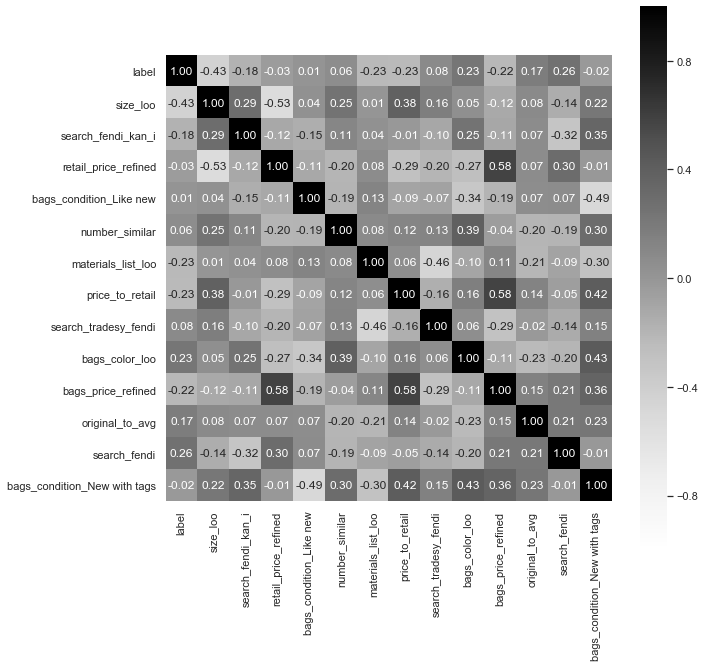

In [27]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1)
sns.heatmap(df_train[cols].corr(), annot = True, square=True, fmt='.2f', vmin=-1, vmax=1, center= 0, cmap= 'Greys')


# ROC curves

In [42]:
import warnings
warnings.filterwarnings("ignore")

# load libraries
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [29]:
# Get predicted probabilities
y_score1 = test_results_df['svm_prob_false']
y_score2 = test_results_df['lr_prob_false']
y_score3 = test_results_df['xgb_prob_false']
y_score4 = test_results_df['ensemble_prob_false']

# Plot Receiving Operating Characteristic Curve
# Create true and false positive rates
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(test_results_df['label'], y_score1)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(test_results_df['label'], y_score2)
false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(test_results_df['label'], y_score3)
false_positive_rate4, true_positive_rate4, threshold4 = roc_curve(test_results_df['label'], y_score4)
print('roc_auc_score for DecisionTree: ', roc_auc_score(test_results_df['label'], y_score1))
print('roc_auc_score for Logistic Regression: ', roc_auc_score(test_results_df['label'], y_score2))
print('roc_auc_score for XGBoost: ', roc_auc_score(test_results_df['label'], y_score3))
print('roc_auc_score for Ensemble: ', roc_auc_score(test_results_df['label'], y_score4))

roc_auc_score for DecisionTree:  0.6433823529411764
roc_auc_score for Logistic Regression:  0.3455882352941177
roc_auc_score for XGBoost:  0.875
roc_auc_score for Ensemble:  0.7683823529411764


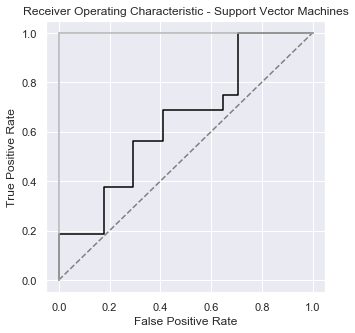

In [30]:
plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - Support Vector Machines')
plt.plot(false_positive_rate1, true_positive_rate1, color='Black')
plt.plot([0, 1], ls="--", color='Grey')
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

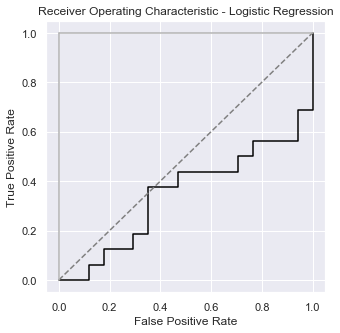

In [31]:
plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate2, true_positive_rate2, color='Black')
plt.plot([0, 1], ls="--", color='Grey')
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

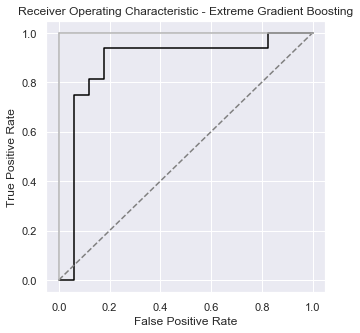

In [32]:
plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - Extreme Gradient Boosting')
plt.plot(false_positive_rate3, true_positive_rate3, color='Black')
plt.plot([0, 1], ls="--", color='Grey')
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

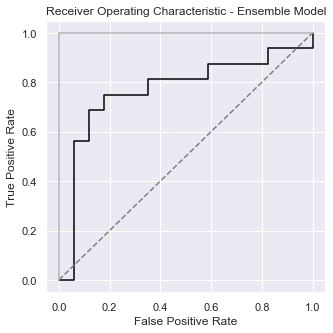

In [33]:
plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - Ensemble Model')
plt.plot(false_positive_rate4, true_positive_rate4, color='Black')
plt.plot([0, 1], ls="--", color='Grey')
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Shap

In [34]:
shap.initjs()

In [35]:
explainer = shap.TreeExplainer(xgb_clf)

In [36]:
shap_values = explainer.shap_values(X.as_matrix())

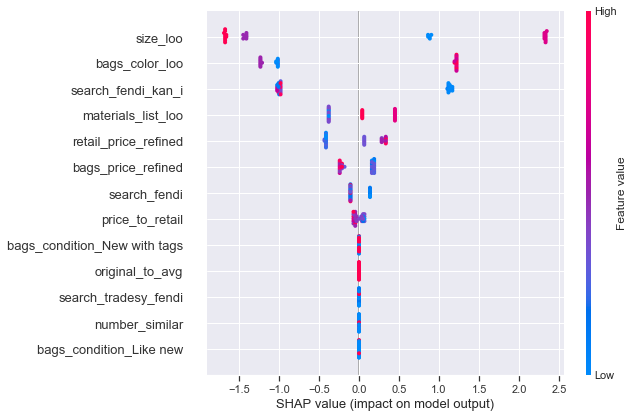

In [37]:
shap.summary_plot(shap_values, X)

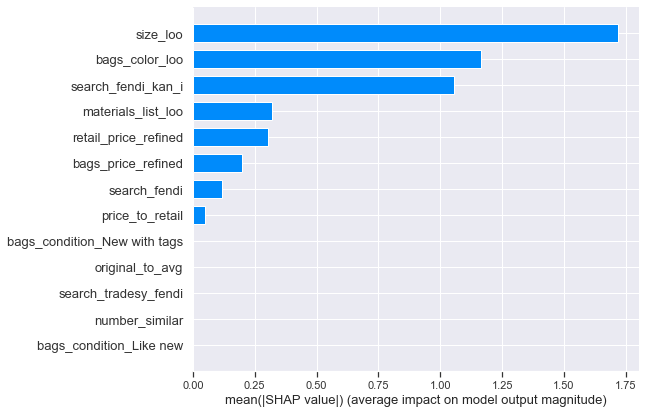

In [38]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [39]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [40]:
shap.force_plot(explainer.expected_value, shap_values, X)